In [2]:
import json
import numpy as np
import os
import pandas as pd
import string
from copy import deepcopy
from pprint import pprint
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

DATA_DIR = '{}/research/data'.format(os.getenv('HOME'))
seed = 42

In [ ]:
decomp_type = 'decom-bridge'  # 'decom-bridge', 'decom-intersec', 'onehop'
split = 'dev'  # 'train', 'dev'

# filepath = 'out/scorer/dev_class_scores.json'
filepath = 'out/' + decomp_type + '/' + split + '_predictions.json'

with open(filepath, 'r') as f:
    data = json.load(f)

key = list(data.keys())[3]
pprint(data[key])

In [ ]:
labeled_ids = {}
for decomp_type in ['bridge', 'intersec']:
    labeled_ids[decomp_type] = {}
    for split in ['train', 'dev']:
        filepath = 'data/decomposition-data/decomposition-' + decomp_type + '-' + split + '-v1.json'

        with open(filepath, 'r') as f:
            data = json.load(f)

        labeled_ids[decomp_type][split] = [i['id'] for i in data['data']]
        print(decomp_type, split, len(labeled_ids[decomp_type][split]))

In [ ]:
for labeled_id in labeled_ids[decomp_type.replace('decom-', '')][split]:
    print(data[labeled_id])

In [ ]:
# WTQ
split = 'test'  # {'train', 'test'}
wtq_split = 'pristine-unseen-tables' if split == 'test' else 'training'

df_subq = pd.read_csv('/Users/ethanperez/research/data/sqa/{}.tsv'.format(split), delimiter='\t', encoding='utf-8')
df_q = pd.read_csv('/Users/ethanperez/research/data/WikiTableQuestions/data/{}.tsv'.format(wtq_split), delimiter='\t', encoding='utf-8')

qids_with_subqs = list(set(df_subq['id']))
qids_with_subqs.sort()

examples = []
for qid in tqdm(qids_with_subqs):
    qid = qid.replace('ns', 'nt')
    assert len(df_q[df_q.id == qid].utterance.values) > 0, 'Invalid QID: {}'.format(qid)
    q = df_q[df_q.id == qid].utterance.values[0]
    df_subq_qid = df_subq[df_subq.id == qid]
    annotators = list(set(df_subq_qid.annotator))
    annotators.sort()
    for annotator in annotators:
        df_subq_qid_annotator = df_subq_qid[df_subq_qid.annotator == annotator]
        positions = list(set(df_subq_qid_annotator.position))
        positions.sort()
        subqs = [df_subq_qid_annotator[df_subq_qid_annotator.position == position].question.values[0].strip() for position in positions]
        example = ' '.join([q] + subqs).strip()
        examples.append(example)

print('Finished processing {} examples!'.format(len(examples)))
print('{:.4f} annotations per questions'.format(len(examples) / len(qids_with_subqs)))

In [ ]:
df_q

In [ ]:
shuffler = random.Random(4)

x = [1,2,3,4,5,6]
shuffler.shuffle(x)
print(x)

x = [1,2,3,4,5,6]
shuffler.shuffle(x)
print(x)

In [ ]:
split = 'train'

shuffler = random.Random(seed)

DATA_DIR = '{}/research/data'.format(os.getenv('HOME'))
file_path = '{}/squad/{}-v2.0.json'.format(DATA_DIR, split)

with open(file_path, 'r') as f:
    data_squad = json.load(f)

titles = []
qs_squad = []
qs_answerable_squad = []
ps_squad = []
quit_loop = False
for article in tqdm(data_squad['data']):
    titles.append(article['title'])
    for paragraph in article['paragraphs']:
        qs_squad += [qa['question'].strip().lower() for qa in paragraph['qas']]
        qs_answerable_squad += [qa['question'].strip().lower() for qa in paragraph['qas'] if not qa['is_impossible']]
        if len(qs_squad) != len(qs_answerable_squad):
            quit_loop = True
            pprint(article)
            break
        ps_squad.append(paragraph['context'].lower().replace(' ', ''))
    if quit_loop:
        break
print(len(qs_squad))
print(len(qs_answerable_squad))

In [6]:
split = 'train'
file_path = '{}/hotpot-orig/hotpot_{}_v1.json'.format(DATA_DIR, split)
with open(file_path, 'r') as f:
    data_hotpot = json.load(f)

In [14]:
# Print Q length statistics
q_lens = np.array([])
for example in data_hotpot:
    q_lens = np.append(q_lens, len(example['question'].strip().split()))
print(q_lens.mean())
q_lens.sort()
print(q_lens)
print(np.histogram(q_lens, bins=10))
for i in range(50):
    print(i, '{0:.2f}'.format(float((q_lens <= i).mean())))

17.818401937046005
[  3.   3.   4. ... 104. 106. 108.]
(array([33115, 42031, 10062,  2736,  1548,   609,   248,    68,    19,
          11]), array([  3. ,  13.5,  24. ,  34.5,  45. ,  55.5,  66. ,  76.5,  87. ,
        97.5, 108. ]))


In [4]:
titles_hotpot = []
qs_hotpot = []
for article in data_hotpot['data']:
    for paragraph in article['paragraphs']:
        titles_hotpot.append(paragraph['title'].strip())
        for qa in paragraph['qas']:
            qs_hotpot.append(qa['question'].strip())

TypeError: list indices must be integers or slices, not str

In [ ]:
num_over_max_len = 0
max_len = 256

num_index_errors = 0
supporting_sents = []
for example in data_hotpot:
    question_words = example['question'].split(' ')
    example_supporting_sents = []
    gold_paragraph_over_max_len = False
    for sf_title, sf_sent_index in example['supporting_facts']:
        for context_title, context_sents in example['context']:
            if context_title == sf_title:
                if sf_sent_index >= len(context_sents):
                    num_index_errors += 1
                    continue
                example_supporting_sents.append(context_sents[sf_sent_index])
                gold_paragraph_words = (' '.join(context_sents)).split(' ')
                input_len = len(question_words) + len(gold_paragraph_words)
                if input_len > max_len:
                    gold_paragraph_over_max_len = True
                break

    num_over_max_len += gold_paragraph_over_max_len
    supporting_sents.append(example_supporting_sents)

print(num_over_max_len, num_index_errors)

In [ ]:
data_hotpot[1]['question']

In [ ]:
matching_ps = 0
for supporting_sent_set in tqdm(supporting_sents):
    for supporting_sent in supporting_sent_set:
        supporting_sent_lower_alpha_only = lower_alpha_only(supporting_sent)
        if supporting_sent_lower_alpha_only[:30] in ps_lower_alpha_only:
            matching_ps += 1
            print(matching_ps)
print(matching_ps)

In [ ]:
'wefa,23roagg-3  2..'.translate(str.maketrans('', '', string.punctuation)).replace(' ', '')

In [ ]:
def lower_alpha_only(text):
    return ''.join(list(filter(lambda x: x.isalpha(), text))).lower()

In [ ]:
ps_lower_alpha_only = lower_alpha_only(''.join(ps))

In [ ]:
lower_alpha_only('wefa,23roagg-3  2..')

In [ ]:
num_over_max_len = 0
max_len = 300
for example_hotpot in data_hotpot:
    question_words = example_hotpot['question'].split(' ')
    for title, paragraph in example_hotpot['context']:
        paragraph_words = (' '.join(paragraph)).split(' ')
        input_len = len(question_words) + len(paragraph_words)
        if input_len > max_len:
            num_over_max_len += 1
print(num_over_max_len)

In [ ]:
qtypes = {}

for data in data_hotpot:
    if data['level'] != 'easy':
        qtypes[data['type']] = qtypes.get(data['type'], 0) + 1

print(qtypes)

In [ ]:
for i, data in enumerate(data_hotpot):
    if i == 1000:
        break
    elif data['type'] == 'comparison':
        print(data['question'])
    

In [ ]:
with open('/Users/ethanperez/research/data/hotpot-all/train.json', 'r') as f:
    data_hotpot_all = json.load(f)
print(len(data_hotpot_all))

In [ ]:
data_hotpot_all['data'][0]

In [ ]:
for i in range(10):
    print(data_hotpot_all['data'][i]['paragraphs'][0]['qas'][0]['answers'])

In [ ]:
with open('/Users/ethanperez/research/DecompRC/DecompRC/out/hotpot/test_nbest_predictions.json', 'r') as f:
    subq_pred_answers = json.load(f)

In [ ]:
for subqid, prediction in subq_pred_answers.items():
    pprint(subqid)
    pprint(prediction)
    break
#     title, answers = prediction
#     if answers[0] != 'None':
#         print(answers[0])

In [ ]:
with open('/Users/ethanperez/research/DecompRC/DecompRC/data/hotpot-all/test.json', 'r') as f:
    subqs = json.load(f)

In [ ]:
pprint(subqs)

In [ ]:
num_answerable = 0
for qa in subqs['data'][0]['paragraphs'][0]['qas']:
    top_answer = subq_pred_answers[qa['id']][0]
    print(qa['question'], top_answer['text'], top_answer['probability'], top_answer['logit'], top_answer['no_answer_logit'])
    if (top_answer['logit'] - 3.) > top_answer['no_answer_logit']:
        num_answerable += 1
#     if qa['id'] == '5a7a06935542990198eaf050-1':
#         print(qa)
#         break
print(num_answerable)

In [ ]:
subqs['data'][0]['paragraphs'][0]['context']

In [ ]:
nl_subqs_dir = '/Users/ethanperez/research/data/decomposition-data-nq-version'

data = {}
for nl_subqs_filepath in os.listdir(nl_subqs_dir):
    if nl_subqs_filepath == 'human_sub_questions_bridge.json':
        continue
    with open(os.path.join(nl_subqs_dir, nl_subqs_filepath), 'r') as f:
        new_data = json.load(f)
    print(nl_subqs_filepath, len(new_data), 'examples!')
    data.update(new_data)
# pprint(data)

In [ ]:
with open(os.path.join(nl_subqs_dir, 'human_sub_questions_bridge.json'), 'r') as f:
    human_subqs = json.load(f)
pprint(human_subqs)

In [ ]:
num_subqs = []
for qid, q in human_subqs.items():
    num_subqs.append(len(q['sub-questions']))
num_subqs = np.array(num_subqs)
print(num_subqs.mean())

In [ ]:
(num_subqs == 2).sum()

In [ ]:
len(data)

In [ ]:
sum([200, 200, 152, 66])

In [ ]:
for qid, q in data.items():
    print('{}\n  1) {}\n  2) {}'.format(q['question'].capitalize(), q['subquestion1'].capitalize(), q['subquestion2'].capitalize()))

In [ ]:
os.listdir(nl_subqs_dir)

In [ ]:
# Get IDs for each data split
hotpot_splits = ['train', 'dev_distractor', 'dev_fullwiki', 'test_fullwiki']
ids = {}
for split in hotpot_splits:
    file_path = '{}/hotpot-orig/hotpot_{}_v1.json'.format(DATA_DIR, split)
    with open(file_path, 'r') as f:
        data = json.load(f)
    ids[split] = set([example['_id'] for example in data])

In [ ]:
with open('/Users/ethanperez/research/data/decomposition-data-nq-version/rulebased.json', 'r') as f:
    comparison_subqs = json.load(f)

In [ ]:
# Find which Q's are from which split
num_qs = {split: 0 for split in hotpot_splits}

for qid, subq in comparison_subqs.items():
    for split in hotpot_splits:
        if qid in ids[split]:
            num_qs[split] += 1
pprint(num_qs)

In [ ]:
pprint(comparison_subqs)

In [ ]:
with open('/Users/ethanperez/research/data/hotpot/test.json', 'r') as f:
    hotpot_orig_subqs_dev = json.load(f)

In [ ]:
with open('/Users/ethanperez/research/data/decomposed-predictions/comparison_decomposed_generated_predictions.json') as f:
    all_data = json.load(f)

In [ ]:
for example in all_data['data']:
    qas = example['paragraphs'][0]['qas']
    if (len(qas) > 0) and (qas[0]['level'] == 'subquestion'):
        pprint(example['paragraphs'][0])

In [ ]:
with open('{}/hotpot-all/{}.json'.format('/Users/ethanperez/research/data', 'train')) as f:
    full_data = json.load(f)

id_to_qtype = {}
comparison_qids = set([])
for example in full_data['data']:
    qa = example['paragraphs'][0]['qas'][0]
    id_to_qtype[qa['id']] = qa['type']
    if qa['type'] == 'comparison':
        comparison_qids.add(qa['id'])

In [ ]:
len(comparison_qids)

In [ ]:
dict(filter(lambda k, v: id_to_qtype[k] == 'comparison', }))

In [ ]:
{qid: qinfo for qid, qinfo in {'5a70f0e75542994082a3e408': 1, '5a70eee85542994082a3e3f0': 2}.items() if id_to_qtype[qid] == 'comparison'}

In [ ]:
id_set_len_sum = 0
ids = set([])
for i in range(10):
    with open('/Users/ethanperez/research/pytorch-pretrained-BERT/data/decomposed-predictions/comparison_decomposed_dev_generations.num_shards=10.shard_no={}.json'.format(i), 'r') as f:
        data = json.load(f)
    id_set = set([])
    for example in data['data']:
        id_set.add(example['paragraphs'][0]['qas'][0]['id'])
    print(len(id_set))
    id_set_len_sum += len(id_set)
    ids = ids.union(id_set)
print(len(ids), id_set_len_sum)

In [ ]:
split = 'dev'
num_shards = 100 if split == 'train' else 10

data = {'data': []}
for shard_no in range(num_shards):
    with open('/Users/ethanperez/research/data/decomposed-predictions/comparison_decomposed_{}_generations.num_shards={}.shard_no={}.json'.format(split, num_shards, shard_no), 'r') as f:
        data['data'].append(json.load(f)['data'])
pprint(data['data'][::1000])

In [ ]:
with open('/Users/ethanperez/research/data/hotpot-orig/hotpot_train_v1.json', 'r') as f:
    hotpot_orig = json.load(f)

In [ ]:
a_sep = 'A'
q_sep = 'Q'

def format_text(text):
    return text.lower()

examples = []
missing_sfs = 0
for example in hotpot_orig:
    example_supporting_sents = []
    prev_sf_title = ''
    prev_sf_sent_index = -1
    for sf_title, sf_sent_index in example['supporting_facts']:
        for context_title, context_sents in example['context']:
            if context_title == sf_title:
                if sf_sent_index >= len(context_sents):
                    missing_sfs += 1
                    continue
                if sf_title == prev_sf_title:
                    if sf_sent_index == (prev_sf_sent_index + 1):
                        prepend = ''
                    else:
                        prepend = '... '
                else:
                    prepend = '[' + sf_title.strip() + '] '
                example_supporting_sents.append(prepend + context_sents[sf_sent_index].strip())
        prev_sf_title = sf_title
        prev_sf_sent_index = sf_sent_index
    example_text_input = format_text(' '.join([example['question'].strip()] + example_supporting_sents))
    example_text = example_text_input + ' ' + a_sep + ' ' + format_text(example['answer']) + ' ' + q_sep
    examples.append(example_text)
    print(example_text)
    break
print('missing_sfs', missing_sfs)

In [ ]:
prev_sf_title = ''

In [ ]:
DATA_DIR = '{}/research/data'.format(os.getenv('HOME'))
split = 'train'
task_name = 'hotpotqa-recomposition-supporting-fact'
examples = []


In [ ]:
if os.path.exists(save_filename):
    with open(save_filename, 'r') as f:
        examples = json.load(f)
else:
    save_filename = '{}/hotpot-orig/{}.{}.json'.format(DATA_DIR, task_name, split)
    with open(save_filename, 'w') as f:
        json.dump(examples, f)

In [ ]:
examples

In [ ]:
[] * 2

In [ ]:
# SimpleQuestions: Read Q's
with open('/Users/ethanperez/research/data/SimpleQuestions_v2/annotated_fb_data_valid.txt', 'r') as f:
    lines = f.readlines()

lines = [line.split('\t') for line in lines]
for line in lines:
    print(line[-1])

In [ ]:
for example in data_hotpot:
    pprint(example)
    break

In [ ]:
with open('{}/research/data/hotpot-all/q-subqs-subas.split=train.{}.json'.format(os.getenv('HOME'), base_name), 'r') as f:
    q_subqs_subas_train = json.load(f)

with open('{}/research/data/hotpot-all/q-subqs-subas.split=trainslice.{}.json'.format(os.getenv('HOME'), base_name), 'w') as f:
    json.dump({'data': q_subqs_subas_train['data'][:64]}, f)
# q_subqs_subas_trainslice = {'data': q_subqs_subas_train['data'][:64]}

In [ ]:
'{}/research/data/hotpot-all/q-subqs-subas.split=train.{}.json'.format(os.getenv('HOME'), base_name)

In [ ]:
q_subqs_subas_train['data'][0]['paragraphs'][0]['qas']

In [ ]:
split = 'dev'
file_path = '{}/hotpot-all/{}.json'.format(DATA_DIR, split)
with open(file_path, 'r') as f:
    data_hotpot = json.load(f)

In [ ]:
num_context_words = []
for article in data_hotpot['data']:
    for example in article['paragraphs']:
        for answer, para in zip(example['qas'][0]['answers'], example['context']):
            num_context_words.append(len(para.split()))
            if len(answer) > 0:
                answer = answer[0]
                answer_start = answer['answer_start']
                answer_end = answer_start + len(answer['text'])
                answer_text_from_span = para[answer_start: answer_end]
                if answer['text'] not in ['yes', 'no']:
                    assert answer['text'] == answer_text_from_span, '{} != {}'.format(answer['text'], answer_text_from_span)
num_context_words = np.array(num_context_words)
print(num_context_words.mean())

In [ ]:
(num_context_words > 300).sum()

In [ ]:
num_context_words.shape

In [ ]:
for answer, para in zip(example['qas'][0]['answers'], example['context']):
    if len(answer) > 0:
        answer = answer[0]
        answer_start = answer['answer_start']
        answer_end = answer_start + len(answer['text'])
        answer_text_from_span = para[answer_start: answer_end]
        assert answer['text'] == answer_text_from_span

In [ ]:
para[3:4]

In [ ]:
para[: answer['answer_start'] + len(answer['text'])]

In [ ]:
### Write train slice of SQuAD (article with fewest questions)
with open('/Users/ethanperez/research/data/squad/train-v2.0.json', 'r') as f:
    squad = json.load(f)

In [ ]:
def count_qas(data):
    num_qas = 0
    for article in data['data']:
        for para in article['paragraphs']:
            for qa in para['qas']:
                num_qas += 1
    return num_qas

min_num_qas = count_qas(squad)
squad_tiny = None
for i in range(len(squad['data'])):
    squad_tiny_tmp = {'data': [squad['data'][i]]}
    num_qas = count_qas(squad_tiny_tmp)
    if num_qas < min_num_qas:
        print(i, num_qas)
        squad_tiny = squad_tiny_tmp
        min_num_qas = num_qas

In [ ]:
with open('/Users/ethanperez/research/data/squad/trainslice-v2.0.json', 'w') as f:
    f.write(json.dumps(squad_tiny, indent=2, sort_keys=False))

In [ ]:
### Write train slice of SQuAD (article with fewest questions)
with open('/Users/ethanperez/research/data/hotpot-all/train.json', 'r') as f:
    hotpot = json.load(f)

In [ ]:
with open('/Users/ethanperez/research/data/hotpot-all-slice/train.json', 'w') as f:
    f.write(json.dumps({'data': hotpot['data'][:4]}, indent=2, sort_keys=False))
with open('/Users/ethanperez/research/data/hotpot-all-slice/dev.json', 'w') as f:
    f.write(json.dumps({'data': hotpot['data'][:4]}, indent=2, sort_keys=False))

In [ ]:
{'data': hotpot['data'][:4]}

In [ ]:
num_answers_per_q = []
for article in hotpot['data'][:100]:
    for para in article['paragraphs']:
        for qa in para['qas']:
            num_answers = 0
            for answer in qa['answers']:
                if len(answer) > 0:
                    num_answers += len(answer) > 0
            num_answers_per_q.append(num_answers)
num_answers_per_q = np.array(num_answers_per_q)
print((num_answers_per_q == 0).mean())

In [ ]:
### Write train slice of SQuAD (article with fewest questions)
with open('/Users/ethanperez/research/data/hotpot-orig/hotpot_train_v1.json', 'r') as f:
    hotpot_orig = json.load(f)

In [ ]:
# example_key = list(hotpot_orig.keys())[0]
pprint(hotpot_orig[0])

In [ ]:
qa['answers'][-2][0]['text']

In [ ]:
split = 'train'
file_path = '{}/hotpot-orig/hotpot_{}_v1.json'.format(DATA_DIR, split)
with open(file_path, 'r') as f:
    data_hotpot = json.load(f)

In [ ]:
num_over_max_len = 0
max_len = 256
sf_sents_with_answer = []

num_index_errors = 0
supporting_sents = []
for example in data_hotpot:
    question_words = example['question'].split(' ')
    example_supporting_sents = []
    gold_paragraph_over_max_len = False
    span_q = example['answer'].lower().strip() not in ['yes', 'no']
    example_sf_sents_with_answer = 0
    for sf_title, sf_sent_index in example['supporting_facts']:
        for context_title, context_sents in example['context']:
            if context_title == sf_title:
                if sf_sent_index >= len(context_sents):
                    num_index_errors += 1
                    continue
                sf_sent = context_sents[sf_sent_index]
                example_supporting_sents.append(sf_sent)
                
                if span_q:
                    example_sf_sents_with_answer += example['answer'] in sf_sent
                
                gold_paragraph_words = (' '.join(context_sents)).split(' ')
                input_len = len(question_words) + len(gold_paragraph_words)
                if input_len > max_len:
                    gold_paragraph_over_max_len = True
                break
    if span_q:
        sf_sents_with_answer.append(example_sf_sents_with_answer)
#         if example_sf_sents_with_answer == 0:
#             pprint(example)

    num_over_max_len += gold_paragraph_over_max_len
    supporting_sents.append(example_supporting_sents)

sf_sents_with_answer = np.array(sf_sents_with_answer)
print(num_over_max_len, num_index_errors)

In [ ]:
(sf_sents_with_answer == 0).sum()

In [ ]:
# Count # Q words in test set
split = 'train'
file_path = '{}/hotpot-orig/hotpot_{}_v1.json'.format(DATA_DIR, split)
with open(file_path, 'r') as f:
    data_hotpot = json.load(f)

num_question_words = []
for example in data_hotpot:
    num_question_words.append(len(example['question'].strip().split()))
    if num_question_words[-1] > 40:
        print(example['question'])
num_question_words = np.array(num_question_words)

print(num_question_words.mean())
num_question_words.sort()
print(num_question_words[-100:])

In [ ]:
### Write train slice of SQuAD (article with fewest questions)
with open('/Users/ethanperez/research/data/squad/train-v2.0.json', 'r') as f:
    squad = json.load(f)

In [ ]:
squad_num_question_words = []
for article in squad['data']:
    for para in article['paragraphs']:
        for qa in para['qas']:
            squad_num_question_words.append(len(qa['question'].strip().split()))
squad_num_question_words = np.array(squad_num_question_words)
print(squad_num_question_words.mean())
squad_num_question_words.sort()
squad_num_question_words[-100:]

In [ ]:
# Examining NBest Predictions file
with open('/Users/ethanperez/research/pytorch-transformers/checkpoint/hotpot.bs=16.lr=0.00002.nte=4/nbest_predictions_.json', 'r') as f:
    nbest_predictions = json.load(f)

In [ ]:
nbest_predictions['5a8aee3d55429950cd6afc01.9']

In [ ]:
# Count # Q words in test set
split = 'dev_distractor'
file_path = '{}/hotpot-orig/hotpot_{}_v1.json'.format(DATA_DIR, split)
with open(file_path, 'r') as f:
    data_hotpot = json.load(f)

In [ ]:
data_hotpot

In [ ]:
# Add SQuAD 2.0 Q's to Hotpot Q's (all in SQuAD format)
for split in ['train', 'dev_distractor']:
    file_path = '{}/hotpot-slice/hotpot_{}_v1_slice.json'.format(DATA_DIR, split)
    with open(file_path, 'r') as f:
        data_hotpot = json.load(f)

    with open('{}/squad-slice/{}-v2.0-slice.json'.format(DATA_DIR, split.replace('_distractor', '').replace('_fullwiki', '')), 'r') as f:
        data_squad = json.load(f)

    print('# articles before combining:', len(data_hotpot['data']), len(data_squad['data']))
    data_hotpot['data'] += data_squad['data']
    print('# articles after combining: ', len(data_hotpot['data']))

    os.makedirs('{}/hotpot-squad-slice'.format(DATA_DIR), exist_ok=True)
    with open('{}/hotpot-squad-slice/hotpot_{}_v1_slice.json'.format(DATA_DIR, split), 'w') as f:
        f.write(json.dumps(data_hotpot, indent=2))

In [ ]:
split = 'dev_distractor'
with open('{}/hotpot-squad/hotpot_{}_v1.json'.format(DATA_DIR, split), 'r') as f:
    data_hotpot_squad = json.load(f)
with open('{}/hotpot-all/q-subqs-subas.split={}.filter_name=bi-cond-lm.top_knn=10.max_mods_per_nn=4.json'.format(DATA_DIR, split.replace('_distractor', ''))) as f:
    q_subqs_subas = json.load(f)

In [ ]:
for q_index, subq_example in enumerate(q_subqs_subas['data']):
    example_q_subqs_subas = subq_example['paragraphs'][0]['qas'][0]['question']
    qid = subq_example['paragraphs'][0]['qas'][0]['id']
    pprint(example_q_subqs_subas)
    print(qid)
    for i in range(10):
        subqid = qid + '.' + str(i)
        assert qid == data_hotpot_squad['data'][q_index]['paragraphs'][i]['_id'], 'Error retrieving question with matching QID'
        assert len(data_hotpot_squad['data'][q_index]['paragraphs'][i]['qas']) == 1, 'Unexpected # QAs'
        pprint(data_hotpot_squad['data'][q_index]['paragraphs'][i]['qas'][0]['question'])
    break


In [ ]:
len(data_hotpot_squad['data'][0]['paragraphs'])

In [ ]:
print(len(data_hotpot_squad['data']))
print(len(q_subqs_subas['data']))

In [ ]:
data_hotpot_squad['data'][0]

In [ ]:
# Count # of words/Q in HotpotQA
with open('/Users/ethanperez/research/data/hotpot/hotpot_train_v1.json', 'r') as f:
    data_hotpot = json.load(f)

In [ ]:
num_q_words = []
for example in data_hotpot['data']:
    for paragraph in example['paragraphs']:
        for qa in paragraph['qas']:
            num_q_words.append(len(qa['question'].strip().split()))
num_q_words = np.array(num_q_words)
print(num_q_words.mean())

In [58]:
# Read in DecompRC intermediate output questions/answers
decomposition_predictions = {}
for qtype in ['intersec', 'bridge']:
    with open('/Users/ethanperez/research/data/decomposed-predictions/{}_decomposed_train_nbest_predictions.json'.format(qtype), 'r') as f:
        decomposed_predictions[qtype] = json.load(f)

In [63]:
decomposed_predictions['bridge']['5a8005b75542992bc0c4a681']

[{'evidence': "<title> metrovías </title> metrovías s.a. is an argentine privately owned company that operates the buenos aires underground and the metropolitan services of @@ urquiza line. @@ 90% of metrovías' shares are held by grupo roggio. <title> tbilisi metro </title> the tbilisi metro (georgian: თბილისის მეტროპოლიტენი ) is a rapid transit metro system in tbilisi, georgia. opened on 11 december @@ 1966, @@ it was the fourth metro system in the former soviet union. like most ex-soviet metros, most of the stations are very deep and vividly decorated",
  'queries': 'metrovías operates which transit metro system  urquiza line  first opened in which year ?',
  'text': '1966',
  'logit': [56.189032554626465, 52.928449630737305]},
 {'evidence': "<title> metrovías </title> metrovías s.a. is an argentine privately owned company that operates the buenos aires underground and the metropolitan services of @@ urquiza line. @@ 90% of metrovías' shares are held by grupo roggio. <title> metrorai

In [60]:
len(decomposed_predictions['intersec'])

58525

In [ ]:
pprint(decomposed_predictions['5a70eee85542994082a3e3f0'])

In [44]:
# filename = 'decomposition-comparison-train-nq.json'
# filename = 'decomposition-comparison-dev-nq.json'
# filename = 'rulebased.json'
filename = 'decomposition-bridge-train-v1.json'
with open('/Users/ethanperez/research/data/decomposition-data/{}'.format(filename), 'r') as f:
    decomposed_data = json.load(f)

In [50]:
len(decomposed_data['data'])

200

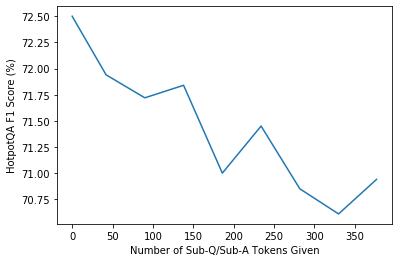

In [78]:
f1s = [72.5, 71.94, 71.72, 71.84, 71, 71.45, 70.85, 70.61, 70.94]
input_length = [0,42,90,138,186,234,282,330,377]
plt.plot(input_length, f1s)
plt.ylabel('HotpotQA F1 Score (%)')
plt.xlabel('Number of Sub-Q/Sub-A Tokens Given')
plt.savefig('/Users/ethanperez/research/data/acc-by-subq-suba-tokens.pdf', format='pdf')

In [79]:
with open('/Users/ethanperez/Downloads/hotpot_dev_1hop_solv_nonsolv.json', 'r') as f:
    onehop_solved_qids = json.load(f)
print(len(onehop_solved_qids['1hop_solv']))
print(onehop_solved_qids['1hop_solv'][:10])

3426
['5a7cd0fd55429909bec76823', '5ae0a74e554299603e41842f', '5ae35c945542992e3233c3bd', '5ade063d5542995b365fabcd', '5a8841195542994846c1ce65', '5ae5e0a6554299546bf82fa9', '5adfa3da554299025d62a317', '5a77a14655429949eeb29f13', '5a8e5a635542990e94052ae4', '5ab2d3c5554299295394687a']


In [83]:
f1s = np.array([71.74,72.11,71.27,71.88,71.99,72.11,72.29,71.76,70.58,72.17])
f1s.sort()
print(f1s)

[70.58 71.27 71.74 71.76 71.88 71.99 72.11 72.11 72.17 72.29]


In [95]:
np.median(f1s)

71.935

In [82]:
f1s.std()

0.4883850939576281